In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.integrate import solve_ivp
from network import network
from training import trainNetwork, trainNetworkFirst
from dynamics import *
from generateData import assembleData
from torchdiffeq import odeint

##### Test with continuous output in scipy.solve_ivp

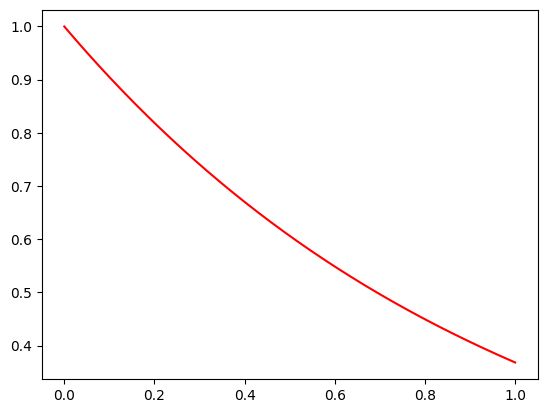

In [2]:
f = lambda t,y : -y
T = 1
y0 = np.array([1.])
soln = solve_ivp(f, [0,T], y0, dense_output = True)
y = lambda t : soln.sol(t).reshape(*t.shape)
time = np.linspace(0,T,1000)
plt.plot(time,y(time),'r-')
plt.show();

In [3]:
system="Robert"

In [4]:
d = 3 #dimension of the phase space

if system=="SIR":
    t_min = 0.
    t_max = 1e4
    y0 = np.array([0.3,0.5,0.2])
else:
    t_min = 0. #initial time
    t_max = 1e6 #final time
    y0 = np.array([1.,0.,0])

In [5]:
output = solve_ivp(ode,[t_min,t_max], y0, method = 'BDF', atol=1e-4, rtol=1e-4, args=(system,))
sol,time = output.y,output.t

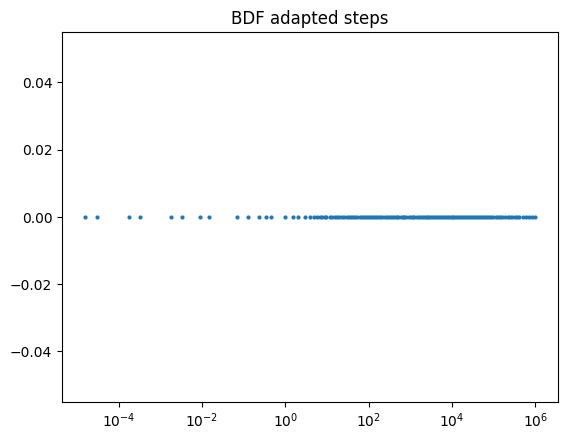

In [6]:
plt.semilogx(time,time*0,'o',markersize=2)
plt.title("BDF adapted steps")
plt.show();

In [7]:
M = len(time)
N = min(7,M)

which_idxs = lambda n, m: np.rint(
      np.linspace(1,m, min(n,m))-1).astype(int) 

coarse_time = time[which_idxs(N+1,M)]
initial_guesses = sol[:,which_idxs(N+1,M)]
dts = np.diff(coarse_time)

$$
\mathcal{D} = \{(t_j,\Phi^{t_j}(x_i))\}_{i=1,...,N}^{j=1,...,M},\,\,\{x_1,...,x_N\}\subset\Omega\subset\mathbb{R}^3,\,\,t_j\in [0,\Delta t]
$$

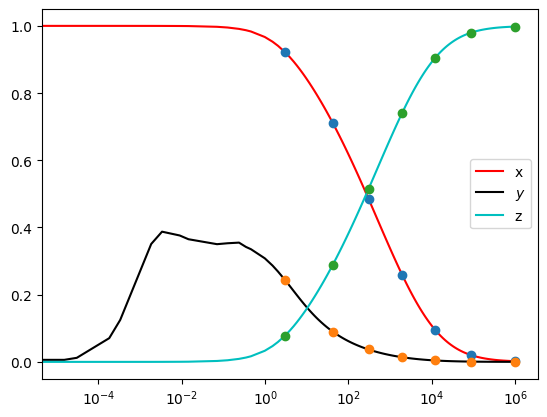

In [8]:
fact = 1e4 * (system=="Robert") + 1. * (system=="SIR")

plt.semilogx(time,sol[0],'r-',label='x')
plt.semilogx(coarse_time,initial_guesses[0],'o')
plt.semilogx(time,sol[1]*fact,'k-',label=r'$y$')
plt.semilogx(coarse_time,initial_guesses[1]*fact,'o')
plt.semilogx(time,sol[2],'c-',label='z')
plt.semilogx(coarse_time,initial_guesses[2],'o')
plt.legend()
plt.show();

In [49]:
networks = []

lr = 1e-2
wd = 1e-5
epochs = 10000
tol = 1e-6

is_converged = False
sol_k = np.zeros((N+1,d)) #current
sol_km = np.zeros((N+1,d)) #previous

sol_k[0] = initial_guesses[:,0]
sol_km[0] = initial_guesses[:,0]

k = 0

data = {f"n={i}": None for i in range(N)}


while is_converged==False and k<1:
    
    print(f"\n\n We are at iterate {k} of the parareal training procedure \n\n")    
    
    if k==0:
        for n in range(N):
            dt = coarse_time[n+1]-coarse_time[n]
            tt = torch.tensor([[dt]],dtype=torch.float32)
            if n==0:
                yy0 = torch.from_numpy(initial_guesses[:,n].astype(np.float32)).unsqueeze(0)
            else:
                yy0 = pred.detach().clone()
            yy = torch.from_numpy(initial_guesses[:,n+1].astype(np.float32)).unsqueeze(0)
            data[f"n={n}"] = [tt,yy,yy0]
            networks.append(network(d))
            trainNetworkFirst(networks[-1],data[f"n={n}"])
            pred = networks[-1](tt,yy0)
            print("Prediction : ",pred)
            sol_k[n+1] = pred.detach().cpu().numpy()[0]
            sol_km[n+1] = pred.detach().cpu().numpy()[0]
    else:
        lr = lr / 2
        
        time_span = np.array([0,coarse_time[1]-coarse_time[0]])
        tt,sol,y0 = assembleData(sol_km[0],time_span,system,derivative=False)
        
        sol_k[1] = sol[-1].detach().cpu().numpy() #We correct it based on Parareal
        
        for n in np.arange(1,N):
            
            print(f"\n\n The considered time interval now is [{coarse_time[n]},{coarse_time[n+1]}] \n\n")
            #We use the previously trained network as an initial guess
            dt = coarse_time[n+1]-coarse_time[n]
            time_span = np.linspace(0,dt,50)
            #This is to train the coarse predictor at the current update of the initial condition
            
            y0old = torch.from_numpy(sol_km[n].astype(np.float32)).repeat(len(time_span),1)
            y0new = torch.from_numpy(sol_k[n].astype(np.float32)).repeat(len(time_span),1)
            dataComputed = assembleData(sol_km[n],time_span,system) #with the fine integrator applied to the previous approximation
            data[f"n={n}"] = dataComputed

            loss_is_large = trainNetwork(y0old,y0new,networks[n],d,lr,wd,epochs,system,data[f"n={n}"])
            
            tt = torch.tensor([[dt]],dtype=torch.float32)
            coarse_pred_previous = networks[n](tt,y0old[0:1]).detach().cpu().numpy()[0]
            coarse_pred_current = networks[n](tt,y0new[0:1]).detach().cpu().numpy()[0]
            
            yy = data[f"n={n}"][-1] + coarse_pred_current - coarse_pred_previous
            
            sol_km[n+1] = sol_k[n+1]
            sol_k[n+1] = yy.detach().cpu().numpy()[0]
            
    k+=1



 We are at iterate 0 of the parareal training procedure 


Prediction :  tensor([[9.2342e-01, 2.4389e-05, 7.5911e-02]], grad_fn=<AddBackward0>)
Prediction :  tensor([[7.0746e-01, 9.5104e-06, 2.9050e-01]], grad_fn=<AddBackward0>)
Prediction :  tensor([[4.8519e-01, 4.0550e-06, 5.1452e-01]], grad_fn=<AddBackward0>)
Prediction :  tensor([[2.5879e-01, 1.0025e-06, 7.4232e-01]], grad_fn=<AddBackward0>)
Prediction :  tensor([[9.5583e-02, 2.7001e-07, 9.0584e-01]], grad_fn=<AddBackward0>)
Prediction :  tensor([[2.2322e-02, 3.8445e-07, 9.8166e-01]], grad_fn=<AddBackward0>)
Prediction :  tensor([[2.4062e-03, 1.3447e-08, 9.9883e-01]], grad_fn=<AddBackward0>)


In [50]:
coarse_preds = sol_k.T

In [51]:
output = solve_ivp(ode,[t_min,t_max], np.array([1.,0.,0.]), method = 'BDF', atol=1e-10, rtol=1e-10, args=(system,))
sol,time = output.y,output.t

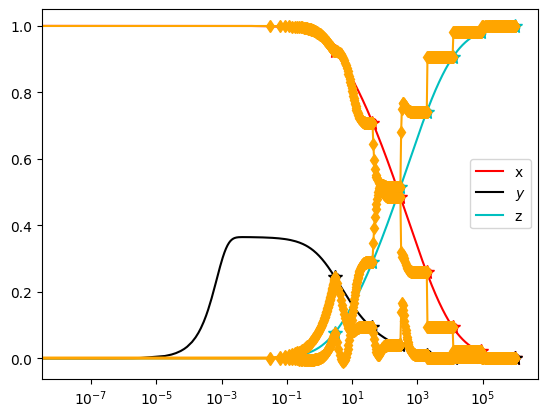

In [59]:
plt.semilogx(time,sol[0],'r-',label='x')
plt.semilogx(coarse_time,initial_guesses[0],'ro')
plt.semilogx(coarse_time,coarse_preds[0],'r*',markersize=10)
plt.semilogx(time,sol[1]*fact,'k-',label=r'$y$')
plt.semilogx(coarse_time,initial_guesses[1]*fact,'ko')
plt.semilogx(coarse_time,coarse_preds[1]*fact,'k*',markersize=10)
plt.semilogx(time,sol[2],'c-',label='z')
plt.semilogx(coarse_time,initial_guesses[2],'co')
plt.semilogx(coarse_time,coarse_preds[2],'c*',markersize=10)

for n in range(N):
    tt = torch.linspace(0,coarse_time[n+1]-coarse_time[n],100).unsqueeze(1)
    yy = torch.from_numpy(coarse_preds[:,n].astype(np.float32)).unsqueeze(0).repeat(len(tt),1)
    preds = networks[n](tt,yy).detach().cpu().numpy()
    times = np.linspace(coarse_time[n],coarse_time[n+1],len(tt))
    plt.plot(times,preds[:,0],'-d',c='orange')
    plt.plot(times,preds[:,1]*fact,'-d',c='orange')
    plt.plot(times,preds[:,2],'-d',c='orange')
    
plt.legend()
plt.show();

$$
\mathrm{Loss}(W) = \frac{1}{50}\sum_{n=0}^{N-1} \sum_{k=1}^{50}\left\|\tilde{\boldsymbol{x}}\left(W_n\right)\left(t_n, t_{n, k}, \overline{\boldsymbol{x}}_n\right)-\Psi_F^{t_{n, k}-t_n}\left(\overline{\boldsymbol{x}}_n\right)\right\|_2^2,\,\, W=(W_0,...,W_{N-1})
$$
$$
\overline{\boldsymbol{x}}_0 = \boldsymbol{x}_0,\quad \overline{\boldsymbol{x}}_{n+1} = \tilde{\boldsymbol{x}}\left(W_n\right)\left(t_n, t_{n+1}, \overline{\boldsymbol{x}}_n\right)
$$
$$
t_{n,k} = t_n + k\Delta t_n / 50,\,\,\Delta t_n = t_{n+1}-t_n
$$


$$
\mathcal{N}\left(W_n\right)\left(t_{n, k}-t_n, \overline{\boldsymbol{x}}_n\right) = P\circ \sigma \circ L_2 \circ \sigma \circ L_1\left(\frac{t_{n,k}-t_n}{\Delta t_n},\overline{\boldsymbol{x}}_n\right),\,\,\mathcal{N}(W_n):\mathbb{R}^4 \rightarrow\mathbb{R}^3
$$
$$
\tilde{\boldsymbol{x}}\left(W_n\right)\left(t_n,t_{n, k}, \overline{\boldsymbol{x}}_n\right) = \overline{\boldsymbol{x}}_n + \left(\mathcal{N}\left(W_n\right)\left(t_{n, k}-t_n, \overline{\boldsymbol{x}}_n\right) - \mathcal{N}\left(W_n\right)\left(0, \overline{\boldsymbol{x}}_n\right) \right)\odot \begin{bmatrix}1 \\ 10^{-4} \\ 1\end{bmatrix}
$$

**Iterate 0 :**

$x_0$

Dataset : $\{\Psi^{t_{i,0}}(\bar{x}_0^0)\}$ and train $\tilde{x}(W_0^0)$ to it matches this observations, then I define

$$
\bar{x}_1^0 := \tilde{x}(W_0^0)(t_1,t_0,\bar{x}_0^0)
$$

Dataset : $\{\Psi^{t_{i,1}}(\bar{x}_1^0)\}$ and train $\tilde{x}(W_1^0)$ to it matches this observations, then I define

$$
\bar{x}_2^0 := \tilde{x}(W_1^0)(t_2,t_1,\bar{x}_1^0)
$$
and so on...

**Iterate 1 :**

Set $\bar{x}_0^1=\bar{x}_0^0$

Dataset : $\{\Psi^{t_{i,0}}(\bar{x}_0^0)\}$ and train $\tilde{x}(W_0^1)$ to it matches this observations, then I define

$$
\bar{x}_1^1 := \tilde{x}(W_0^1)(t_1,t_0,\bar{x}_0^1)
$$

Dataset : $\{\Psi^{t_{i,1}}(\bar{x}_1^0)\}$ and train $\tilde{x}(W_1^1)$ to it matches this observations, then I define

$$
\bar{x}_2^1 := \tilde{x}(W_1^1)(t_2,t_1,\bar{x}_1^1)
$$
and so on...


$$
\tilde{x}(W^k)(t_0,t,x_0)
$$
$$
x^{(k+1)}(t) = \tilde{x}(W^{k+1})(t_0,t,x_0) + (\Psi^{t-t_n}_F(x^{(k)}(t_n)) - \tilde{x}(W^{k})(t_0,t,x_0))
$$